### Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import platform

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

from keras.applications import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

In [ ]:
# Import other libraries
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
from PIL import Image
from sklearn.model_selection import KFold
import zipfile

In [ ]:
# Setup Mixed Precision

# Detect TPY
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else:
  policyConfig = 'mixed_float16'

policy = tf.keras.mixed_precision.Policy(policyConfig)
# tf.keras.mixed_precision.set_global_policy(policy)

### Load and process the (augmented) dataset

In [ ]:
file_path = 'augmented_data.npz'
loaded_data = np.load(file_path, allow_pickle = True)

# Access the 'data' and 'labels' arrays
X = loaded_data['data']
labels = loaded_data['labels']

print(len(X))
print(len(labels))

X = X.astype('float32') / 255

healthy = []
unhealthy = []

# Iterate through the images to separate them into the proper set
for i, image in enumerate(X):
    if labels[i] == 'unhealthy':
        unhealthy.append(image)
    else:
        healthy.append(image)

np.random.shuffle(healthy)
np.random.shuffle(unhealthy)
# ChatGPT suggests to shuffle images to avoid batches containing the same images

print(len(healthy))
print(len(unhealthy))

In [ ]:
# Codifica delle etichette 'healthy' e 'unhealthy' in numeri
label_dict = {'healthy': 0, 'unhealthy': 1}
y = np.array([label_dict[label] for label in labels]) # 0 è [1,0]

# Convert labels to one-hot encoding format
y = keras.utils.to_categorical(y,2)

# Split data into train_val and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, random_state=seed, test_size=0.3, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, random_state=seed, test_size=0.3, stratify=y_temp)


# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

# Print shapes of the datasets
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")


In [ ]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 32
epochs = 100

img_height = 96
img_width = 96

# Print input shape, batch size, and number of epochs
print(f"Input Shape: {input_shape}, Output Shape: {output_shape}, Batch Size: {batch_size}, Epochs: {epochs}")

### Setup the model

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=30, restore_best_weights=True, mode='auto'),
]

In [ ]:
# Macs with Apple Silicon suffer performance penalties when using the modern Adam optimizer
# Detect system specs and select the appropriate optimizer

if platform.system() == "Darwin" and platform.processor() == "arm":
    optimizer = tf.keras.optimizers.legacy.Adam()
else:
    optimizer = tf.keras.optimizers.Adam()

In [21]:
# Load the VGG16 model pre-trained on ImageNet data
vgg16 = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the weights of the VGG16 model
vgg16.trainable = False

# Create a new model on top of the VGG16 model
model = Sequential()
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))  # Add Dropout layer with a dropout rate of 0.5
model.add(Dense(2, activation='sigmoid'))  # Binary classification, so use a sigmoid activation

# Compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

# Add EarlyStopping callback to monitor validation loss and stop training if it doesn't improve
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 15895106 (60.64 MB)
Trainable params: 1180418 (4.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


### Train the model

In [23]:
tl_history = model.fit(
    x=preprocess_input(X_train * 255),
    y=y_train,
    batch_size=128,
    epochs=200,
    validation_data=(preprocess_input(X_val * 255), y_val),
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
74/74 [==============================] - 12s 157ms/step - loss: 0.1952 - accuracy: 0.9314 - val_loss: 0.5945 - val_accuracy: 0.8322
Epoch 2/200
74/74 [==============================] - 11s 155ms/step - loss: 0.1953 - accuracy: 0.9328 - val_loss: 0.5880 - val_accuracy: 0.8350
Epoch 3/200
74/74 [==============================] - 11s 156ms/step - loss: 0.1928 - accuracy: 0.9312 - val_loss: 0.6030 - val_accuracy: 0.8346
Epoch 4/200
74/74 [==============================] - 12s 157ms/step - loss: 0.2114 - accuracy: 0.9215 - val_loss: 0.5972 - val_accuracy: 0.8357
Epoch 5/200
74/74 [==============================] - 12s 157ms/step - loss: 0.1938 - accuracy: 0.9300 - val_loss: 0.6353 - val_accuracy: 0.8183
Epoch 6/200
74/74 [==============================] - 11s 155ms/step - loss: 0.1941 - accuracy: 0.9300 - val_loss: 0.5943 - val_accuracy: 0.8322
Epoch 7/200
74/74 [==============================] - 11s 155ms/step - loss: 0.1869 - accuracy: 0.9358 - val_loss: 0.6031 - val_accuracy:

In [24]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}_trained.zip"
model.save(zipfile_name)

### Fine-Tuning

In [25]:
#Re-load the model after transfer learning
ft_model = keras.models.load_model(zipfile_name)
ft_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 2)                 514       
                                                                 
Total params: 15895106 (60.64 MB)
Trainable params: 1180418 (4.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [26]:
# Set all MobileNetV2 layers as trainable
ft_model.get_layer('vgg16').trainable = True
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)

0 input_2 True
1 block1_conv1 True
2 block1_conv2 True
3 block1_pool True
4 block2_conv1 True
5 block2_conv2 True
6 block2_pool True
7 block3_conv1 True
8 block3_conv2 True
9 block3_conv3 True
10 block3_pool True
11 block4_conv1 True
12 block4_conv2 True
13 block4_conv3 True
14 block4_pool True
15 block5_conv1 True
16 block5_conv2 True
17 block5_conv3 True
18 block5_pool True


In [27]:
# Freeze first N layers, e.g., until the 133rd one
N = 133
for i, layer in enumerate(ft_model.get_layer('vgg16').layers[:N]):
  layer.trainable=False
for i, layer in enumerate(ft_model.get_layer('vgg16').layers):
   print(i, layer.name, layer.trainable)
ft_model.summary()

0 input_2 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 False
18 block5_pool False
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4608)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               1179904   
                                                                 
 dropout_1 (Dropout)         (None, 256)            

In [28]:
# Compile the model
ft_model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics='accuracy')

In [29]:
# Fine-tune the model
ft_history = ft_model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = 16,
    epochs = 150,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the MobileNetV2 network
    callbacks = [keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/150
589/589 [==============================] - 18s 28ms/step - loss: 0.3275 - accuracy: 0.8842 - val_loss: 0.6685 - val_accuracy: 0.8091
Epoch 2/150
589/589 [==============================] - 16s 27ms/step - loss: 0.2474 - accuracy: 0.9083 - val_loss: 0.5834 - val_accuracy: 0.8254
Epoch 3/150
589/589 [==============================] - 16s 27ms/step - loss: 0.2341 - accuracy: 0.9141 - val_loss: 0.6763 - val_accuracy: 0.7985
Epoch 4/150
589/589 [==============================] - 16s 27ms/step - loss: 0.2325 - accuracy: 0.9146 - val_loss: 0.5546 - val_accuracy: 0.8329
Epoch 5/150
589/589 [==============================] - 16s 27ms/step - loss: 0.2376 - accuracy: 0.9140 - val_loss: 0.5667 - val_accuracy: 0.8364
Epoch 6/150
589/589 [==============================] - 16s 27ms/step - loss: 0.2269 - accuracy: 0.9136 - val_loss: 0.6449 - val_accuracy: 0.8144
Epoch 7/150
589/589 [==============================] - 16s 27ms/step - loss: 0.2379 - accuracy: 0.9126 - val_loss: 0.5734 - val_ac

In [30]:
# Evaluate the model on the test set
test_accuracy = ft_model.evaluate(preprocess_input(X_test*255),y_test,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8456


In [31]:
# Save the best model
ft_model.save('FineTuningModel')

### Save the model

In [32]:
flip = tf.keras.Sequential([
  tfkl.RandomFlip("vertical"),
])

rotation = tf.keras.Sequential([
  tfkl.RandomRotation(0.2),
])

zoom = tf.keras.Sequential([
  tfkl.RandomZoom(0.2),
])

translation = tf.keras.Sequential([
  tfkl.RandomTranslation(0.2,0.2),
])

contrast = tf.keras.Sequential([
  tfkl.RandomContrast(0.75),
])

def apply_random_brightness(image):
    # Convert to TensorFlow tensor
    image_tensor = tf.convert_to_tensor(image, dtype=tf.float32)

    # Apply random brightness
    brightness_factor = tf.random.uniform([], -0.5, 0.5)  # Adjust the range as needed
    brightened_image = tf.image.adjust_brightness(image_tensor, brightness_factor)

    # Convert back to NumPy array
    brightened_image_np = brightened_image.numpy()

    return brightened_image_np

In [33]:
from datetime import datetime

current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"model_{formatted_datetime}_finetuned.zip"
model.save(zipfile_name)

X_test_1 = X_val
X_test_2 = rotation(X_val)
X_test_3 = flip(X_val)

true_labels = y_val

# Make predictions on each test set
predictions_1 = ft_model.predict(X_test_1)
predictions_2 = ft_model.predict(X_test_2)
predictions_3 = ft_model.predict(X_test_3)

# Assuming binary classification, adjust if needed

best_accuracy_1 = 0.0
limit_1 = 0.0

for limit in range(100):
    predicted_labels_1 = (predictions_1 > (limit / 100.0)).astype(int)
    accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)

    if (accuracy_1 < best_accuracy_1):
        continue

    best_accuracy_1 = accuracy_1
    limit_1 = (limit / 100.0)

best_accuracy_2 = 0.0
limit_2 = 0.0

for limit in range(100):
    predicted_labels_2 = (predictions_2 > (limit / 100.0)).astype(int)
    accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)

    if (accuracy_2 < best_accuracy_2):
        continue

    best_accuracy_2 = accuracy_2
    limit_2 = (limit / 100.0)

best_accuracy_3 = 0.0
limit_3 = 0.0

for limit in range(100):
    predicted_labels_3 = (predictions_3 > (limit / 100.0)).astype(int)
    accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

    if (accuracy_3 < best_accuracy_3):
        continue

    best_accuracy_3 = accuracy_3
    limit_3 = (limit / 100.0)


print("Limit on Test Set 1:", limit_1)
print("Limit on Test Set 2:", limit_2)
print("Limit on Test Set 3:", limit_3)

predicted_labels_1 = (predictions_1 > limit_1).astype(int)
predicted_labels_2 = (predictions_2 > limit_2).astype(int)
predicted_labels_3 = (predictions_3 > limit_3).astype(int)

# Compare the results
accuracy_1 = np.sum(predicted_labels_1 == true_labels) / len(true_labels)
accuracy_2 = np.sum(predicted_labels_2 == true_labels) / len(true_labels)
accuracy_3 = np.sum(predicted_labels_3 == true_labels) / len(true_labels)

print("Accuracy on Test Set 1:", accuracy_1)
print("Accuracy on Test Set 2:", accuracy_2)
print("Accuracy on Test Set 3:", accuracy_3)


final_prediction = []

for i in range(len(predictions_1)):
    healthy_prediction = predicted_labels_1[i] + predicted_labels_2[i] + predicted_labels_3[i]

    if np.sum(healthy_prediction) >= 2:
        final_prediction.append([1])

    else:
        final_prediction.append([0])

final_accuracy = np.sum(final_prediction == true_labels) / len(true_labels)

print("Accuracy of Final Prediction:", final_accuracy)

89/89 [==============================] - 3s 32ms/step
Limit on Test Set 1: 0.49
Limit on Test Set 2: 0.55
Limit on Test Set 3: 0.33
Accuracy on Test Set 1: 1.391643059490085
Accuracy on Test Set 2: 1.3225920679886685
Accuracy on Test Set 3: 1.3264872521246458
Accuracy of Final Prediction: 1.0


Predictions on Test Set 1:
[[2.5852358e-07 9.9999976e-01]
 [1.9150889e-02 9.7824222e-01]
 [2.6963654e-01 7.1852905e-01]
 [9.7214490e-02 8.9839888e-01]
 [4.2193907e-01 5.6496257e-01]
 [9.9824047e-01 1.7545427e-03]
 [6.3769847e-01 3.2738891e-01]
 [3.7959721e-03 9.9609166e-01]
 [1.0389619e-02 9.8918402e-01]
 [3.6231017e-01 6.1375010e-01]]

Predictions on Test Set 2:
[[1.50341639e-05 9.99984741e-01]
 [1.12874851e-01 8.76512051e-01]
 [2.68305808e-01 7.21739411e-01]
 [4.96623695e-01 4.64276433e-01]
 [2.52721697e-01 7.36355066e-01]
 [9.11384106e-01 8.81541446e-02]
 [8.78305793e-01 1.06265619e-01]
 [2.31457591e-01 7.54122317e-01]
 [2.19436903e-02 9.77266431e-01]
 [1.08419225e-01 8.85212660e-01]]

Predictions on Test Set 3:
[[7.6264455e-06 9.9999154e-01]
 [1.6479872e-01 8.2331246e-01]
 [2.6963654e-01 7.1852905e-01]
 [9.7214490e-02 8.9839888e-01]
 [9.3115367e-02 9.0039515e-01]
 [9.9926180e-01 7.4444275e-04]
 [6.3769847e-01 3.2738891e-01]
 [3.7959721e-03 9.9609166e-01]
 [2.6744552e-02 9.7117078e-

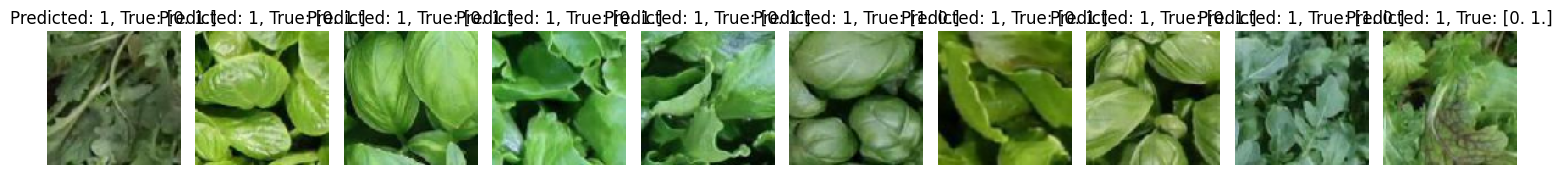

In [34]:
# N predictions to display
N = 10

# Output the first N predictions for each set
print("Predictions on Test Set 1:")
print(predictions_1[:N])

print("\nPredictions on Test Set 2:")
print(predictions_2[:N])

print("\nPredictions on Test Set 3:")
print(predictions_3[:N])

print("\nFinal Predictions:")
print(np.array(final_prediction[:N]))

# Create subplots
fig, axes = plt.subplots(1, N, figsize=(15, 5))

for i in range(N):
    # Plot the original image from X_val
    ax = axes[i]

    # Ensure the image is properly scaled and displayed
    ax.imshow((X_val[i] * 255).astype(np.uint8))

    # Set the title with the predicted and true labels
    ax.set_title(f"Predicted: {final_prediction[i][0]}, True: {true_labels[i]}")

    ax.axis('off')

plt.tight_layout()
plt.show()


### Plot the training

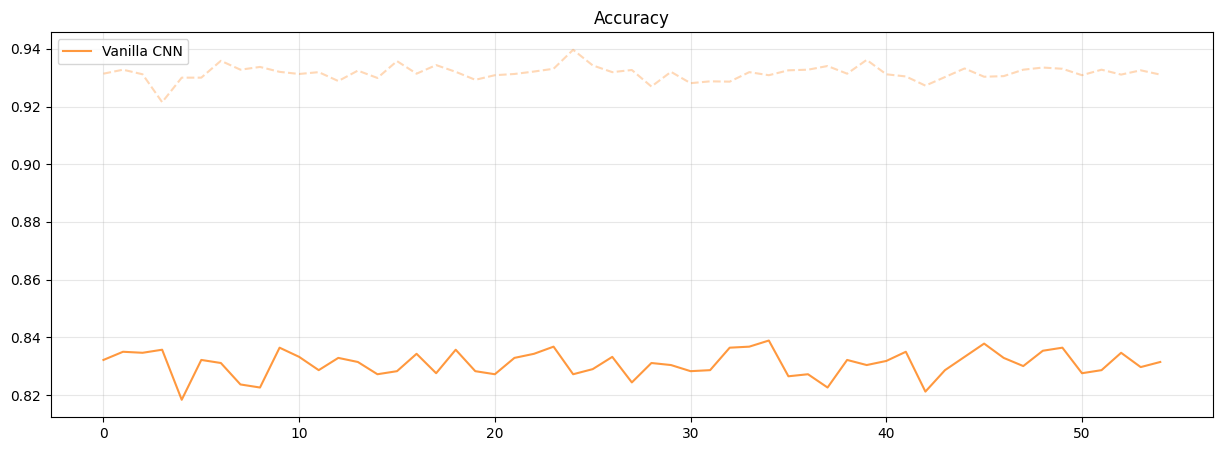

In [35]:
# Plot the training
plt.figure(figsize=(15, 5))
plt.plot(tl_history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(tl_history['val_accuracy'], label='Vanilla CNN', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

# Save the model and create submission

In [36]:
import os
import zipfile
from datetime import datetime
import tensorflow as tf
from os.path import basename

# Specify the name of the submission folder
submission_folder = "SubmissionModel"

# Save best epoch model
model.save(os.path.join(submission_folder, "SubmissionModel"))

# Save the model.py file in the main directory
with open("model.py", "w") as model_file:
    model_file.write("""

import os
import tensorflow as tf

class model:
    def __init__(self, path):
        self.model = tf.keras.models.load_model(os.path.join(path, 'SubmissionModel'))

    def predict(self, X):
        
        # Note: this is just an example.
        # Here the model.predict is called, followed by the argmax
        X = X/255.0
        out = self.model.predict(X)
        out = tf.argmax(out, axis=-1)  # Shape [BS]
        return out

""")

# Create an empty metadata file in the main directory
open("metadata", "w").close()

# Get the current date and time
current_datetime = datetime.now()
formatted_datetime = current_datetime.strftime("%Y%m%d_%H%M%S")

# Create the zipfile with date and time in the name
zipfile_name = f"{submission_folder}_{formatted_datetime}.zip"

with zipfile.ZipFile(zipfile_name, 'w') as zip_file:
    # Add the entire "SubmissionModel" folder and its contents to the archive
    for foldername, subfolders, filenames in os.walk(submission_folder):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            arcname = os.path.relpath(file_path, submission_folder)

            if (foldername in ["SubmissionModel", "SubmissionModel/model", "SubmissionModel/model/variables", "SubmissionModel/variables"]):
                continue

            # print(foldername)
            print(file_path)

            zip_file.write(file_path, arcname)

    # Add other files to the archive (model.py and metadata)
    zip_file.write("model.py", arcname="model.py")
    zip_file.write("metadata", arcname="metadata")

print(zipfile_name)


SubmissionModel/SubmissionModel/fingerprint.pb
SubmissionModel/SubmissionModel/keras_metadata.pb
SubmissionModel/SubmissionModel/saved_model.pb
SubmissionModel/SubmissionModel/variables/variables.data-00000-of-00001
SubmissionModel/SubmissionModel/variables/variables.index
SubmissionModel_20231115_220904.zip
